In [32]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import os
import sys
sys.path.insert(0,'../../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Distances import Distances
from Trajectory import Trajectory
sys.path.insert(1,'../../code/data_utils/')
from ConfigDataset import ConfigDataset
from HiCDataset import HiCDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [33]:
config_fp = '../../data/processed_data.hdf5'
num_bins = 64
resolution = 20_000
mean_dist_fp = '../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

mcool_fp = '../../data/outside/GM12878_hg19.mcool'
interp_nans = False
balance_hic = True
adaptive_coarsegraining = False
adaptive_coarsegraining_cutoff = 3
adaptive_coarsegraining_max_levels = 8

save_dir = './maps_vs_tan_hic_v2/'

# Gen configs
config_directory = '../../data/samples/origami_64_no_embed_reduction/eval_mode/'
aligned_config_directory = '../../data/samples/origami_64_no_embed_reduction/eval_mode/aligned/'
cond_scale = 5.0
rescaled_phi = 8.0
milestone = 120
resolution = 20_000

gm_hic_fp = '../../data/outside/GM12878_hg19.mcool'
imr_hic_fp = '../../data/outside/IMR90_hg19.mcool'

# For loading dcd files
topology_file = aligned_config_directory+'topology.psf'

regions = { # chrom:region_idxs
  '1':[395]#[144,166,200,265,330,395,460,525,590,730,795,860,1260,1325], 
  #'X':[100,236,381,445,553,610,675,810,900,965,1060,1100,1125,1200,1243]
}

In [34]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=num_bins,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=[chrom for chrom in regions],
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)
rosetta = pd.read_pickle(f'../../data/embeddings_{num_bins}_after_transformer/rosetta_stone.pkl')

In [35]:
gm_hic = HiCDataset(gm_hic_fp)
imr_hic = HiCDataset(imr_hic_fp)

In [36]:
def get_genomic_index(chrom,region_idx,rosetta=rosetta):
    return rosetta[chrom][region_idx][-1]
    
def get_tan_coords(chrom,region_idx,config_ds=config_ds):
    chrom = str(chrom)
    start_idx = get_genomic_index(chrom,region_idx) # Get starting position by bp position
    # * 100 to convert to nm
    return Coordinates(config_ds.fetch_specific_coords(chrom=chrom,start_idx=start_idx)[1]*100).float_().cpu_(), start_idx

In [37]:
coords,start = get_tan_coords('1',395)
start = round(start/1_000_000,3)
stop = round(start + 1.28,3)

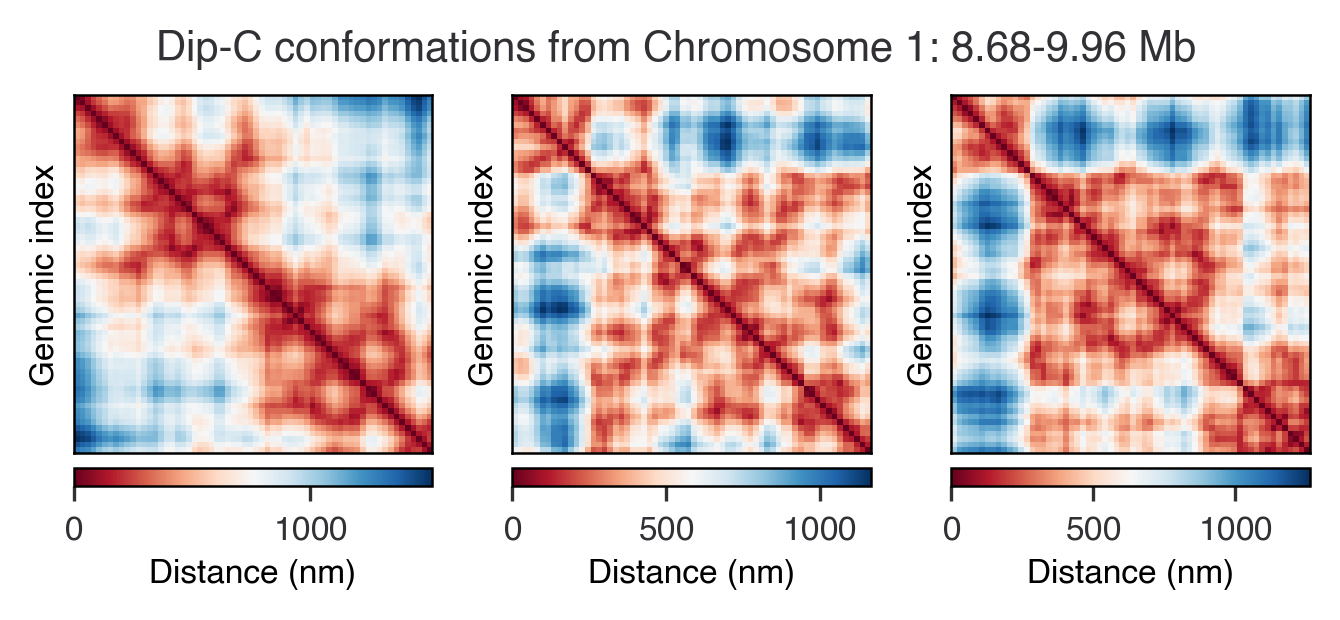

In [45]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(7.08*.62,6.692*.24),layout="constrained")

*_,cbar = coords[3].distances.plot(fig=fig,ax=ax1,cbar_orientation='horizontal')
cbar.set_label('Distance (nm)')
*_,cbar = coords[6].distances.plot(fig=fig,ax=ax2,cbar_orientation='horizontal')
cbar.set_label('Distance (nm)')
*_,cbar = coords[7].distances.plot(fig=fig,ax=ax3,cbar_orientation='horizontal')
cbar.set_label('Distance (nm)')

fig.suptitle(f'Dip-C conformations from Chromosome 1: {start}-{stop} Mb')

fig.savefig('heterogeneity.png')

In [39]:
coords,_ = get_tan_coords('1',395)

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7fdf83c938e0>)

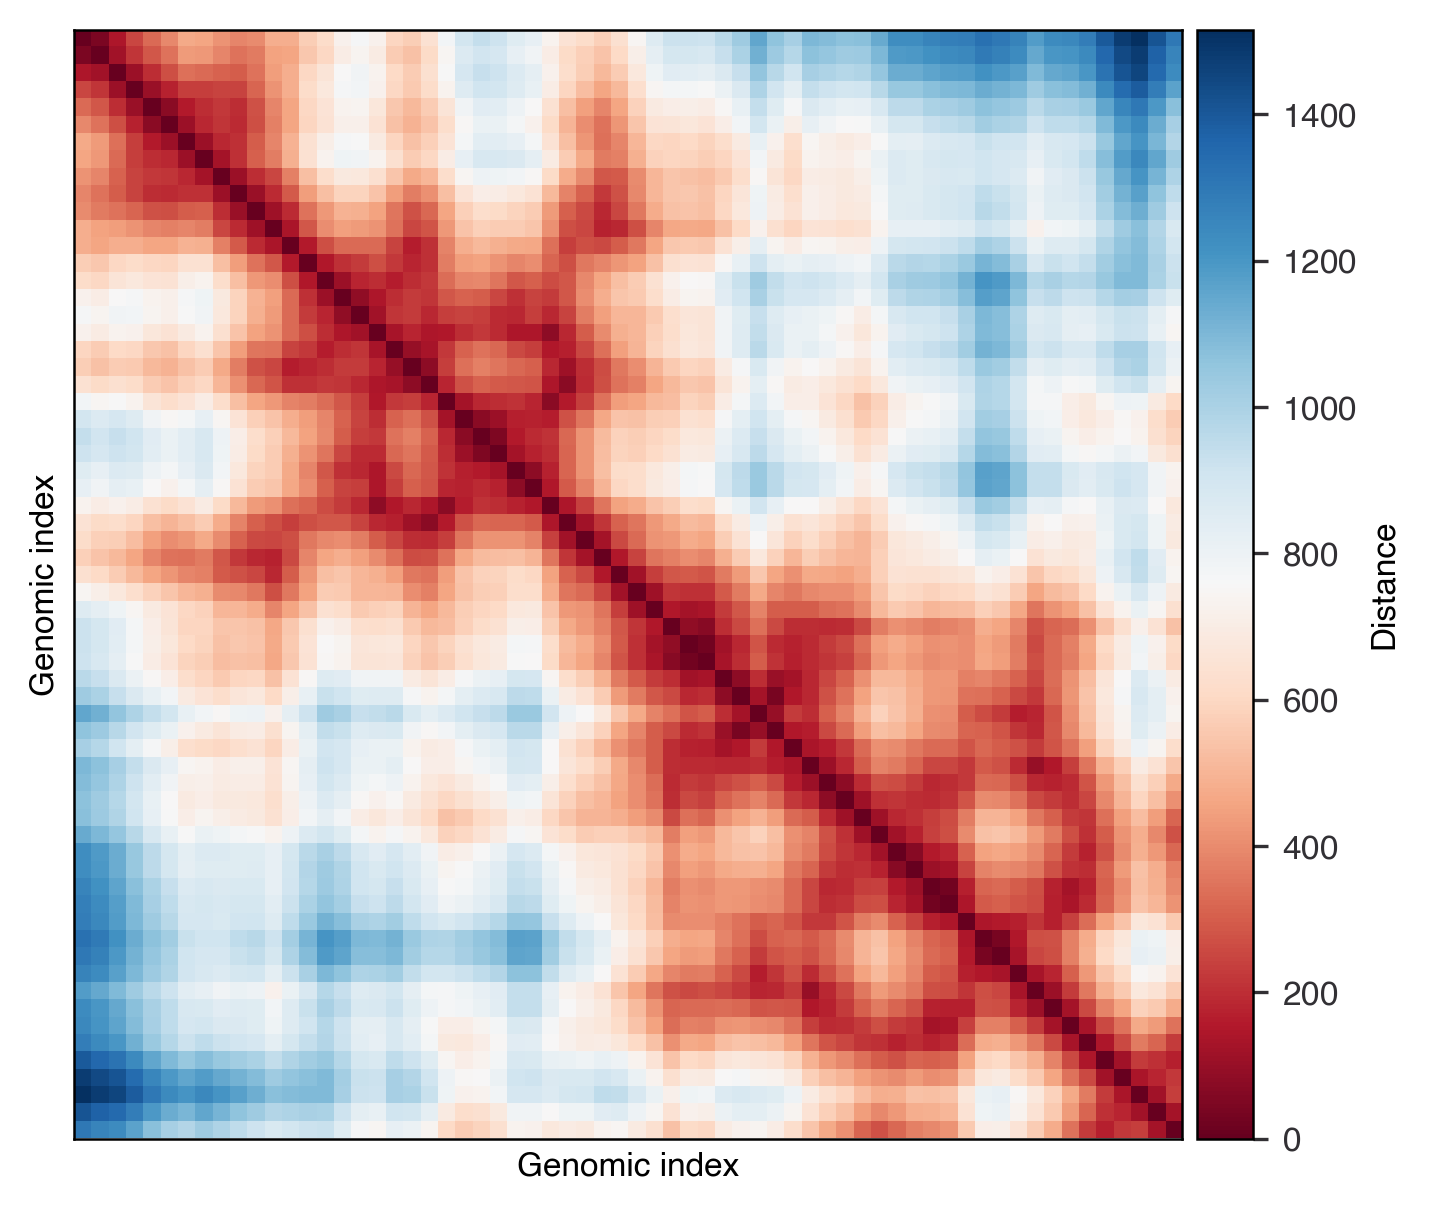

In [40]:
coords[3].distances.plot()

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7fdf83b6c850>)

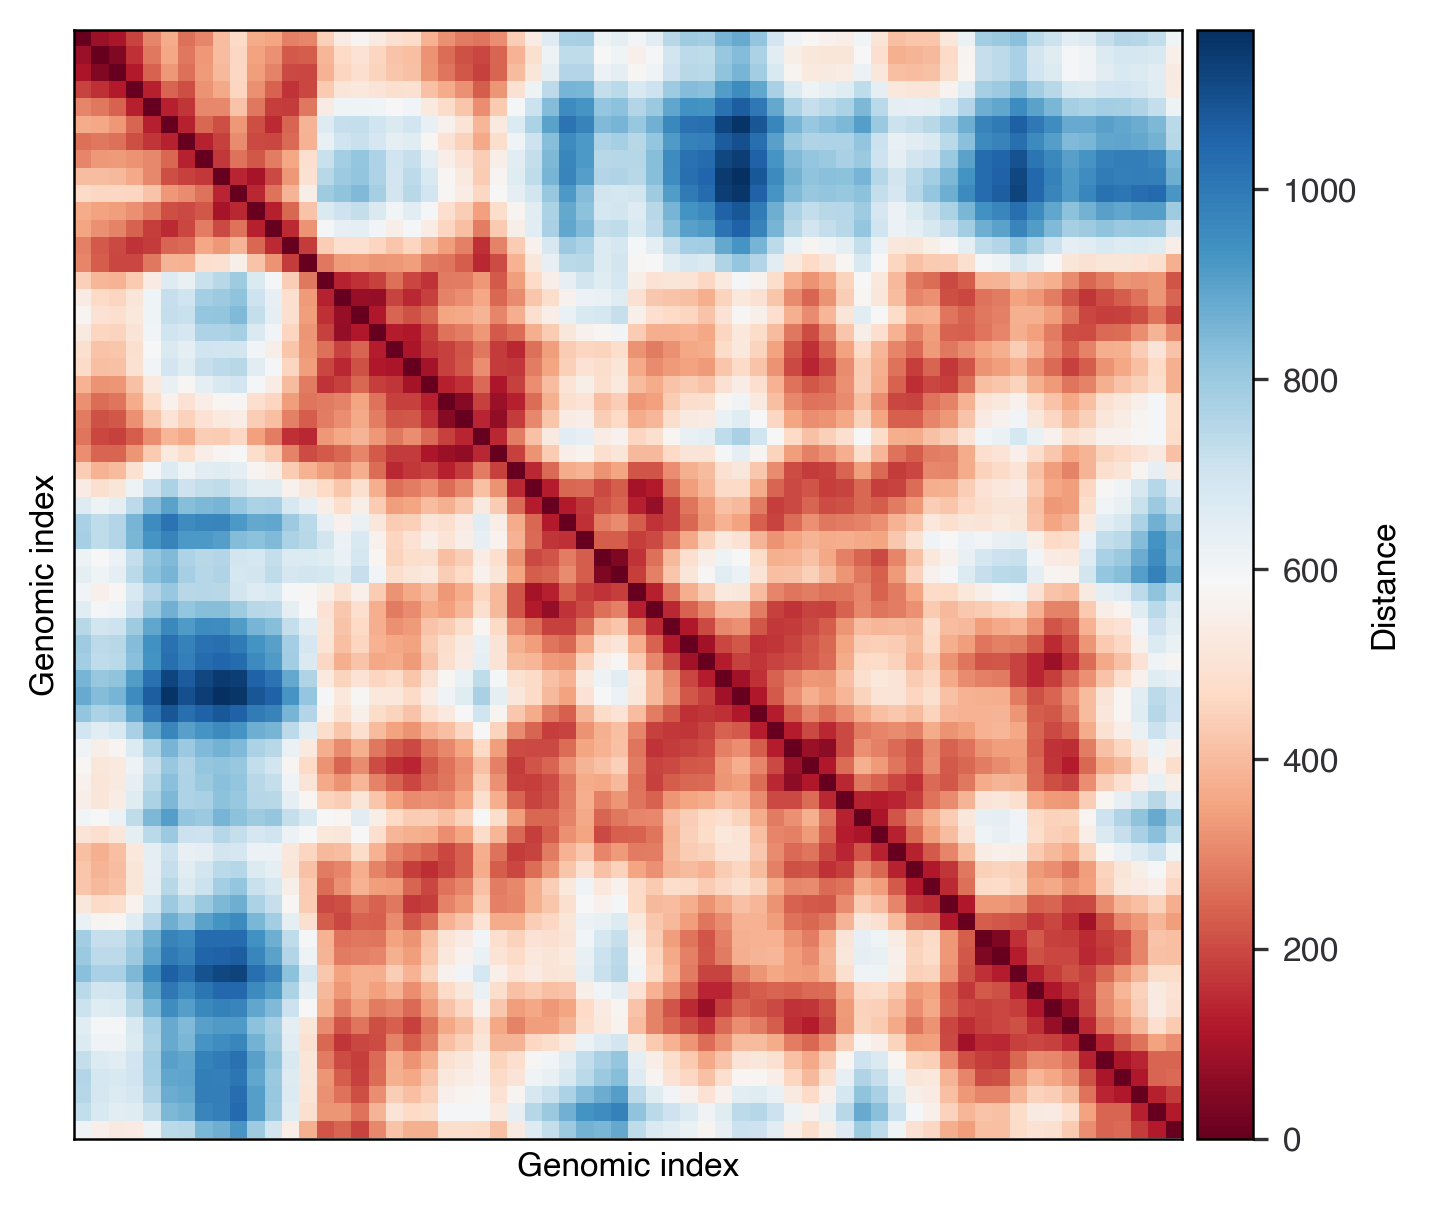

In [41]:
coords[6].distances.plot()

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7fdf83ffb970>)

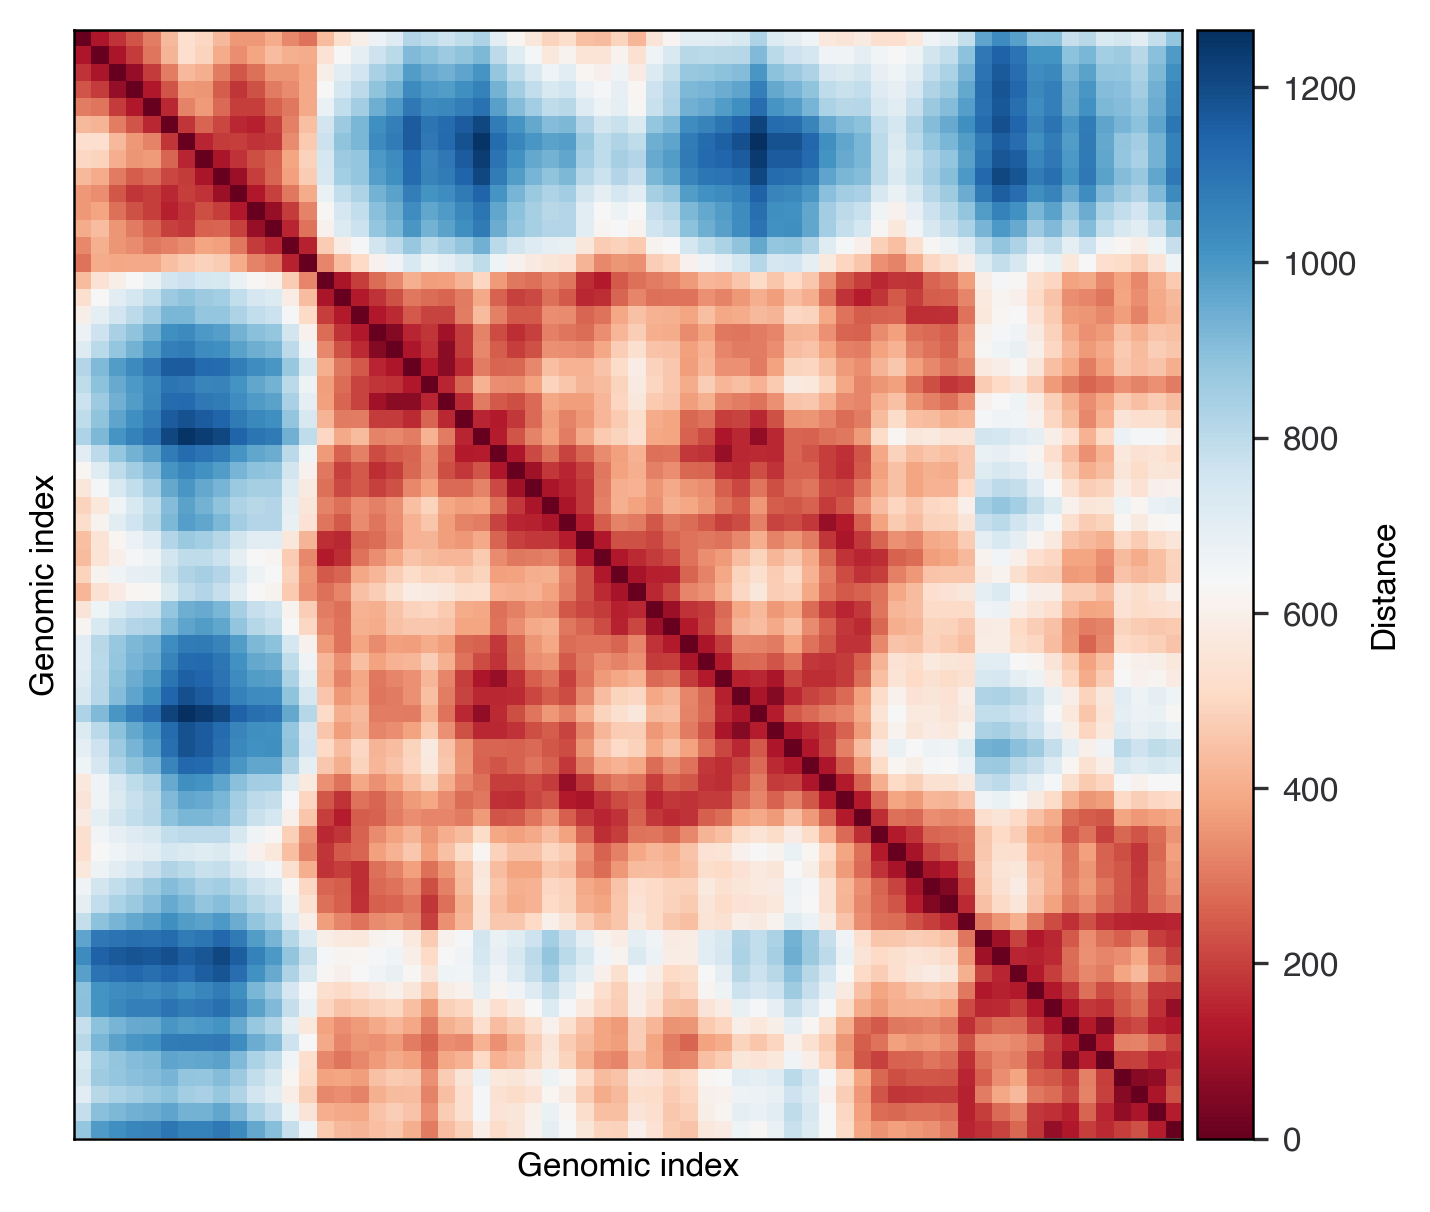

In [42]:
coords[7].distances.plot()

In [43]:
coords1 = coords[(3,6,7),...].trajectory
coords1.mdtraj.center_coordinates()
coords1.mdtraj.xyz/=100
coords1.save_dcd('./tan_conformations.dcd')

Text(0.5, 1.0, 'Experimental Hi-C')

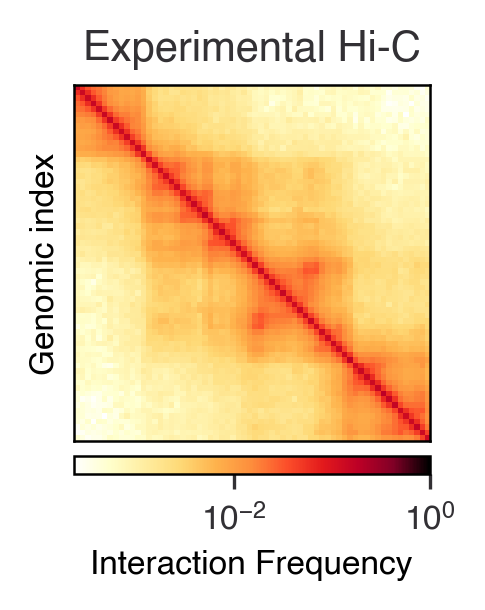

In [44]:
fig,(ax) = plt.subplots(ncols=1, nrows=1, figsize=(7.08*.2,6.692*.24),layout="constrained")
fig,ax,*_=gm_hic.fetch('1',int(start*1_000_000),int(stop*1_000_000)).plot(fig=fig,ax=ax,cbar_orientation='horizontal')
ax.set_title('Experimental Hi-C')

Text(0.5, 1.0, 'Distance map')

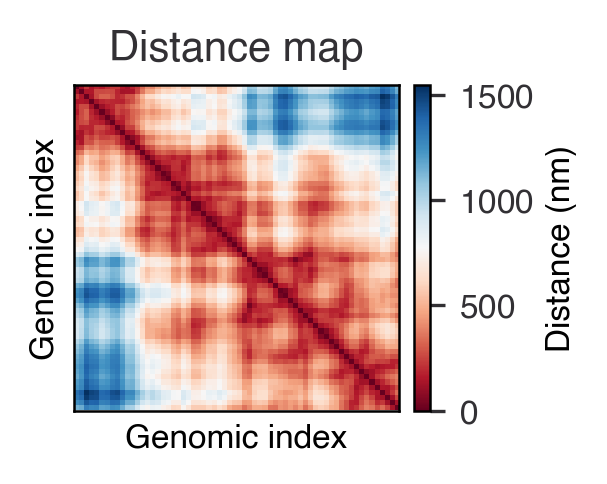

In [47]:
fig,(ax) = plt.subplots(ncols=1, nrows=1, figsize=(7.08*.2,6.692*.24),layout="constrained")
*_,cbar=coords[0].distances.plot(fig=fig,ax=ax)
cbar.set_label('Distance (nm)')
ax.set_title('Distance map')